## Multi-class classification with deep learning neural network
The idea of this notebook is to demonstrate how to test different algorithms with hyperparameter tuning to train a model and how to evaluate a model that has one-level architecture which is a redacted version on my work on a very specific dataset on a totally unrelated topic.


This the Deep Learning neural network for multiclass classification. In order to improve the overall performance of the model, hyperparameter tuning was carried out and at the same time earlystopping and callback were used to prevent overfitting and minimise training time. One Cycle learning rate scheduler technique was also used to get as close to the global optimal as possible.  

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

### 1. Dataset Preparation steps

In [2]:
# Download IRIS dataset for classification problem
from sklearn import datasets
iris = datasets.load_iris()

# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),0
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
df = df.rename(columns = {0:'species'})

In [4]:
print(df.columns.tolist())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']


In [5]:
# If we need to remove any unwanted columns
param_to_remove = ['sepal length (cm)', 'sepal length (cm)']
for col in df.columns.tolist():
    if '(c' in col or 'm)' in col:
        param_to_remove.append(col)

others_to_remove = []

remove_list = param_to_remove + others_to_remove

In [6]:
# Reload the DataFrame
# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df = df.rename(columns = {0:'species'})
df.shape

(150, 5)

In [7]:
# adding three more random label columns
num_rows = df.shape[0]

new_cols = {'Label_1': np.random.choice(['A', 'B', 'C', 'D'], size=num_rows),
            'Label_2': np.random.choice(['A2', 'A2', 'C', 'D'], size=num_rows),
            'Label_3': np.random.choice(['B2', 'B', 'C', 'D'], size=num_rows)}

df = df.assign(**new_cols)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,5.1,3.5,1.4,0.2,0,B,A2,B2
1,4.9,3.0,1.4,0.2,0,A,A2,C
2,4.7,3.2,1.3,0.2,0,C,C,C
3,4.6,3.1,1.5,0.2,0,B,D,B2
4,5.0,3.6,1.4,0.2,0,A,A2,C


In [8]:
# More columns and rows filtering can be done here, in the original data there are others
df["Label_2"] = df.apply(lambda x: 'A' if 'A' in x["Label_2"] else x["Label_2"], axis=1)
df["Label_3"] = df.apply(lambda x: 'B' if 'B' in x["Label_3"] else x["Label_3"], axis=1)

In [9]:
# check for null values, in this case there isn't any because it's a dummy dataset
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [10]:
#Create a new column that collects every labels that exist in a row (except when it's A) which will be used for stratification
key_types = ['species', 'Label_1', 'Label_2', 'Label_3']
df["labels"] = df.apply(lambda x: ','.join(x[x.index.isin(key_types)].index
                                           [x[x.index.isin(key_types)] != 'A' ]), axis=1)

#### Split the df into final_test_set and global_train_set using defect combination

In [11]:
# Find row with a unique combination of types that only have one sample which will create problem during split
df["labels"].value_counts().loc[lambda x: x<2]

Series([], Name: labels, dtype: int64)

In [12]:
# Get the row that have unique combination (we will add them to the test set), before dropping them from the main df
unique_combination_ind = df["labels"].value_counts().loc[lambda x: x<2].index
unique_combination_df = df[df["labels"].isin(unique_combination_ind)]

#print(unique_combination_df)

# drop rows with unique_combination
#print("before drop: ", df.shape)
df = df.drop(df[df["labels"].isin(unique_combination_ind)].index).reset_index(drop=True)
#print("after drop: ", df.shape)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Defect_cat is 0 for without Niv or Nall, 1 for with Niv, Nall, or Both 
for train_index, test_index in split.split(df, df["labels"]):
    Global_train_set = df.loc[train_index]
    Final_test_set_original = df.loc[test_index]

In [15]:
# Add the unique combination rows to the Final_test_set
Final_test_set_original = pd.concat([Final_test_set_original, unique_combination_df], ignore_index=True)

Final_test_set_original["labels"].value_counts()

species,Label_1,Label_3            11
species,Label_1,Label_2,Label_3    11
species,Label_2,Label_3             4
species,Label_3                     4
Name: labels, dtype: int64

In [16]:
# Drop the labels colmun from test and train sets
Global_train_set = Global_train_set.drop("labels", axis=1)
Final_test_set_original = Final_test_set_original.drop("labels", axis=1)

In [17]:
Global_train_set.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
69,5.6,2.5,3.9,1.1,1,C,C,C
132,6.4,2.8,5.6,2.2,2,A,A,B
31,5.4,3.4,1.5,0.4,0,A,D,C
39,5.1,3.4,1.5,0.2,0,B,C,B
36,5.5,3.5,1.3,0.2,0,B,C,B


#### End final test set split

# Classifier Multiclass training

In [18]:
df = Global_train_set.copy()

In [19]:
# Find if there is any column that is not numeric 
df_cat = df.select_dtypes(exclude=[np.number])
#df_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
other_cat_col = []
df[other_cat_col] = df[other_cat_col].astype("category")
#df[other_cat_col].dtypes

In [20]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [21]:
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
#print(df_cat_encoded)

df[df_cat.columns.tolist()] = df_cat_encoded
df[df_cat.columns.tolist()] = df[df_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

end of step 1.

### 2. Train/Val split (normal split here)

In [22]:
y_train = df["species"]
X_train = df.drop("species", axis=1)

In [23]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

end of step 2.

### 3. Data Visualisation on train set

### 4. Oversampling the train set

In [24]:
y_train.value_counts()

1    35
2    34
0    27
Name: species, dtype: int64

In [25]:
#We check the ratio of the labels
y_train.value_counts() / len(y_train)

1    0.364583
2    0.354167
0    0.281250
Name: species, dtype: float64

If the size of class is too different, we can use oversampling below

In [26]:
from collections import Counter
counter = Counter(y_train)
print('Before oversampling', counter)

Before oversampling Counter({1: 35, 2: 34, 0: 27})


In [27]:
oversampling = False

In [28]:
if oversampling:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='not majority', random_state = 42) # sampling_strategy = float only works for Binary 
    
    X_train_pre_transf, y_train_pre_transf = smote.fit_resample(X_train, y_train)
    counter = Counter(y_train_pre_transf)
    print('After', counter)
else:
    X_train_pre_transf = X_train
    y_train_pre_transf = y_train

In [29]:
#print(X_train_pre_transf[df_cat.columns.tolist()].value_counts())
X_train_pre_transf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label_1,Label_2,Label_3
97,6.2,2.9,4.3,1.3,3.0,2.0,0.0
133,6.3,2.8,5.1,1.5,0.0,0.0,0.0
42,4.4,3.2,1.3,0.2,2.0,0.0,0.0
91,6.1,3.0,4.6,1.4,1.0,2.0,1.0
75,6.6,3.0,4.4,1.4,0.0,0.0,1.0


end of step 4.

### 5. Transformation

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer

In [31]:
X_train_set = X_train_pre_transf.copy()

In [32]:
cat_attribs = X_train_set.select_dtypes(include='category').columns.tolist()
#print(cat_attribs)

X_train_num_lst = X_train_set.drop(cat_attribs, axis=1).columns.tolist()
X_train_cat_lst = X_train_set[cat_attribs].columns.tolist()

#print(X_train_num_lst)
#print(X_train_cat_lst)

In [33]:
# Create a transforamtion class to add, combine, fuse, extract features for the numeric PL
# stat_feature_head_to_tail is to use only the absolute 'ab_maximum' or 'average' value of each statistical features  
class Attrib_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, stat_features = 'ab_maximum'):
        self.stat_features = stat_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.stat_features is not None:
            stat_feature = ['sepal', 'petal']
            measurement = ['length', 'width']
            
            new_X = X.copy() # so the original df is not changed
            # See the commnad line argument and match it to pre-defined case 
            match self.stat_features:
                case 'ab_maximum':
                    for stat in stat_features:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        
                        # Get the absolute maximum value of each row, keep the sign, and put them in a new colmun
                        col_name = measure + '_' + self.stat_features
                        row_max = X[meaurement_list].abs().max(axis=1)
                        new_X[col_name] = X[meaurement_list].max(axis=1).mask(lambda x: x < row_max, -row_max)
                        new_X = new_X.drop(meaurement_list, axis=1)
                
                case 'average':
                    for stat in stat_feature:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        # Get the mean value of each row and put them in a new colmun 
                        col_name = measure + '_' + self.stat_features
                        new_X[col_name] = X[meaurement_list].mean(axis=1)
                        new_X = new_X.drop(meaurement_list, axis=1)
                    
                case _:   # 'case _' is for any other input that does not match None or the above
                    sys.exit("please choose from 'ab_maximum', 'average', or \
                    'None' for stat_featurs in Attrib_transformer")
                
            #print(list(new_X.columns))
            return new_X
            
        else:
            return X

In [34]:
# Create a transforamtion class to drop unwanted features
class Attrib_drop(BaseEstimator, TransformerMixin):
    def __init__(self, d_list=[], keep_only_length=False):
        self.d_list = d_list
        self.keep_only_length = keep_only_length
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.keep_only_length:
            Vert_acc_indices = []
            for i, col in enumerate(X.columns):
                if 'length' in col:
                    length_indices.append(i)
            return X.iloc[:,length_indices]
        elif self.d_list:
            keep_indices = []
            for i, col in enumerate(X.columns):
                if col not in self.d_list:
                    keep_indices.append(i)
            return X.iloc[:,keep_indices]
        else:
            return X

In [35]:
# List of the numerical features to be dropped to manually drop columns from the df
drop_list_num = [] # Here we can add columns that should be dropped from the df

num_pl = Pipeline([
    #('imputer', SimpleImputer(strategy="median")),
    ('attrib_transform', Attrib_transformer(stat_features= None)),
    ('attrib_drop', Attrib_drop(keep_only_length=False, d_list=drop_list_num)),
    ('std_scaler', StandardScaler()),
])

#For testing num_pl
#num_prep = num_pl.fit_transform(X_train_set[X_train_num_lst])
#print('shape after transformation: ', num_prep.shape)
#num_prep

In [36]:
# List of the categorical features to be dropped to manually drop columns from the df
drop_list_cat = ['Lane']

cat_pl = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('attrib_drop', Attrib_drop(d_list=drop_list_cat)),
    ('One_Hot', OneHotEncoder(sparse_output=False)),
])

# For testing cat_pl
#cat_prep = cat_pl.fit_transform(X_train_set[X_train_cat_lst])
#cat_prep

In [37]:
full_pl = ColumnTransformer([
    ("num", num_pl, X_train_num_lst),
    ("cat", cat_pl, X_train_cat_lst),
])

X_train_prep = full_pl.fit_transform(X_train_set)

In [38]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (96, 14)


array([[ 0.38410194, -0.38865542,  0.22497286, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.51081598, -0.64420967,  0.7035855 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.89675082,  0.37800732, -1.56982451, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.00975252, -1.41087241, -0.55277266, ...,  1.        ,
         0.        ,  0.        ],
       [-1.13646656,  0.88911582, -1.39034477, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.7779564 , -0.38865542,  1.42150444, ...,  0.        ,
         0.        ,  1.        ]])

#### 5.1 OPTIONAL: PCA for unsupervised feature selectiion

In [39]:
use_PCA = True

if use_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False)
    
    X_train_prep = pca.fit_transform(X_train_prep)
    print('number of components: ', pca.n_components_)

number of components:  7


In [40]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (96, 7)


array([[ 4.78709166e-01, -1.93324252e-01,  1.89616821e-02,
         1.05439574e+00, -5.96767886e-02,  3.50796520e-01,
        -4.67428094e-01],
       [ 1.00876542e+00, -4.65271362e-01, -9.15504150e-01,
        -2.29969164e-01,  5.56465353e-01, -3.29285333e-01,
         5.43700751e-02],
       [-2.84783031e+00, -5.21531690e-01, -6.10356986e-01,
         9.12142287e-03, -5.97634418e-01, -3.40609864e-02,
         7.10563185e-01],
       [ 4.87120370e-01,  1.32342662e-01,  8.71583469e-01,
         3.29588135e-02, -5.50094507e-01, -5.64727357e-01,
        -8.22095400e-01],
       [ 7.73251757e-01,  1.75675233e-01,  1.34932346e-01,
        -1.14448548e+00,  5.71262220e-01, -4.23108563e-01,
        -1.03126852e-01],
       [ 9.55411309e-01,  4.84988913e-01,  1.54675322e-01,
        -1.11482113e+00, -5.09437966e-01, -3.28274271e-02,
        -4.21394936e-01],
       [ 1.92554165e+00,  9.91013519e-01, -9.45482387e-01,
        -1.27940973e-01, -6.37815896e-01,  3.42262761e-03,
        -2.5085765

#### 5.2 Transform X_val as well using the pipeline that has been fitted 

In [41]:
#Transform the X_test as the train set has been transformed
X_val_prep = full_pl.transform(X_val)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_val_prep = pca.transform(X_val_prep)
    print('number of components: ', pca.n_components_)

print('shape after transformation: ', X_val_prep.shape)

number of components:  7
shape after transformation:  (24, 7)


### 6. Train NN

In [42]:
import tensorflow as tf
from tensorflow import keras
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials, space_eval
from hyperopt.early_stop import no_progress_loss
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

In [43]:
# Create a class for onecycle learning rate rescheduler
K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [44]:
input_size = X_train_prep.shape[1]

In [45]:
def build_model(n_hidden, n_neurons, rho, dropout_rate, inputshape=input_size):
    """
    Function to build the neural network model based on the provided hyperparameters.
    
    Args:
        params (dict): Dictionary containing the hyperparameters.
        inputshape (int): Number of input features.
    
    Returns:
        model (Sequential): Compiled Keras model.
    """
    #print(n_hidden, n_neurons, rho, dropout_rate)
    
    model = keras.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal", input_shape=(inputshape,))
    ])

    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"))
        model.add(keras.layers.AlphaDropout(rate=dropout_rate))  # Add AlphaDropout layer with specified dropout rate

    model.add(keras.layers.Dense(3, activation="softmax"))
    optimizer = keras.optimizers.RMSprop(rho=rho)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [46]:
def objective(params):
    """
    Objective function for hyperparameter optimization. Calculates the loss value (1 - accuracy) based on cross-validation.
    
    Args:
        params (dict): Dictionary containing the hyperparameters.
    
    Returns:
        dict: Dictionary containing the loss value, status, and cross-validation score.
    """ 
    mod_params = params.copy()
    mod_params.pop('max_lr')
    mod_params.pop('batch_size')
    n_epochs = 1000
    model = build_model(**mod_params)
    
    #print("params['batch_size']: ", params['batch_size'])
    #print("params['max_lr']: ", params['max_lr'])
    print(params)
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, 
                               restore_best_weights = False)  # Define early stopping callback
    
    onecycle = OneCycleScheduler(math.ceil(len(X_train) / params['batch_size']) * n_epochs, max_rate=params['max_lr'])
    
    model_file = "best_weights.h5" # File to save the best weights
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_loss", mode="min", 
                                                    save_best_only=True, verbose=1) # Define checkpoint to save best weights
    
    history = model.fit(X_train_prep, y_train_pre_transf, callbacks=[early_stop, checkpoint, onecycle], 
                        validation_data=(X_val_prep, y_val), epochs=n_epochs, batch_size=params['batch_size'], verbose=0)
    
    model.load_weights(model_file) # reload the best weights saved by checkpoint
    
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    
    return {'loss': val_loss, 'train_loss': loss, 'status': STATUS_OK, 'model': model, 'history': history} 
    # switch places of the loss varaible so that hyperopt select the best yperparameter based on val_loss instead of loss

In [47]:
search_space = {
    'n_hidden': hp.choice('n_hidden', [4, 9, 14]),  # Hyperparameter space for the number of hidden layers
    'n_neurons': hp.choice('n_neurons', [32, 64, 128]),  # Hyperparameter space for the number of neurons per layer
    'max_lr': hp.loguniform('max_lr', np.log(0.03), np.log(0.05)),  # Hyperparameter space for the max learning rate (1cycle)
    'rho': hp.loguniform('rho', np.log(0.7), np.log(0.99)),  # Hyperparameter space for the momentum
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.4),  # Hyperparameter space for the dropout rate
    'batch_size': hp.choice('batch_size', [32, 48, 64])  # Hyperparameter space for the batch size
}

trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=46, 
            early_stop_fn=no_progress_loss(8), trials=trials)

{'batch_size': 64, 'dropout_rate': 0.37690446216767304, 'max_lr': 0.03373909723766116, 'n_hidden': 9, 'n_neurons': 64, 'rho': 0.7077285727937878}
                                                                           
Epoch 1: val_loss improved from inf to 1.37978, saving model to best_weights.h5

                                                                           
Epoch 2: val_loss improved from 1.37978 to 1.01889, saving model to best_weights.h5

  0%|                               | 0/46 [00:02<?, ?trial/s, best loss=?]

C:\Users\chonl\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



                                                                           
Epoch 3: val_loss improved from 1.01889 to 0.81255, saving model to best_weights.h5

                                                                           
Epoch 4: val_loss improved from 0.81255 to 0.71043, saving model to best_weights.h5

                                                                           
Epoch 5: val_loss improved from 0.71043 to 0.70457, saving model to best_weights.h5

                                                                           
Epoch 6: val_loss did not improve from 0.70457

                                                                           
Epoch 7: val_loss did not improve from 0.70457

                                                                           
Epoch 8: val_loss did not improve from 0.70457

                                                                           
Epoch 9: val_loss did not improve from 0.70457

                     

                                                                           
Epoch 13: val_loss did not improve from 0.48023

                                                                           
Epoch 14: val_loss did not improve from 0.48023

                                                                           
Epoch 15: val_loss did not improve from 0.48023

                                                                           
Epoch 16: val_loss did not improve from 0.48023

                                                                           
Epoch 17: val_loss did not improve from 0.48023

                                                                           
Epoch 18: val_loss did not improve from 0.48023

                                                                           
Epoch 19: val_loss did not improve from 0.48023

                                                                           
Epoch 20: val_loss did not improve from 0.48023



                                                                           
Epoch 45: val_loss did not improve from 0.38643

                                                                           
Epoch 46: val_loss did not improve from 0.38643

                                                                           
Epoch 47: val_loss did not improve from 0.38643

                                                                           
Epoch 48: val_loss did not improve from 0.38643

                                                                           
Epoch 49: val_loss did not improve from 0.38643

                                                                           
Epoch 50: val_loss did not improve from 0.38643

                                                                           
Epoch 51: val_loss did not improve from 0.38643

                                                                           
Epoch 52: val_loss did not improve from 0.38643



                                                                           
Epoch 13: val_loss did not improve from 0.35460

                                                                           
Epoch 14: val_loss did not improve from 0.35460

                                                                           
Epoch 15: val_loss did not improve from 0.35460

                                                                           
Epoch 16: val_loss did not improve from 0.35460

                                                                           
Epoch 17: val_loss did not improve from 0.35460

                                                                           
Epoch 18: val_loss did not improve from 0.35460

                                                                           
Epoch 19: val_loss did not improve from 0.35460

                                                                           
Epoch 20: val_loss did not improve from 0.35460



                                                                           
Epoch 33: val_loss did not improve from 0.88832

                                                                           
Epoch 34: val_loss improved from 0.88832 to 0.86965, saving model to best_weights.h5

                                                                           
Epoch 35: val_loss improved from 0.86965 to 0.80509, saving model to best_weights.h5

                                                                           
Epoch 36: val_loss did not improve from 0.80509

                                                                           
Epoch 37: val_loss did not improve from 0.80509

                                                                           
Epoch 38: val_loss did not improve from 0.80509

                                                                           
Epoch 39: val_loss did not improve from 0.80509

                                                   

                                                                           
Epoch 41: val_loss did not improve from 0.44312

                                                                           
Epoch 42: val_loss did not improve from 0.44312

                                                                           
Epoch 43: val_loss did not improve from 0.44312

                                                                           
Epoch 44: val_loss did not improve from 0.44312

                                                                           
Epoch 45: val_loss did not improve from 0.44312

                                                                           
Epoch 46: val_loss did not improve from 0.44312

{'batch_size': 48, 'dropout_rate': 0.3016263809313312, 'max_lr': 0.031109958265912535, 'n_hidden': 14, 'n_neurons': 64, 'rho': 0.7023936012267143}
                                                                           
Epoch 1: val_loss improved 

                                                                           
Epoch 6: val_loss did not improve from 0.71849

                                                                           
Epoch 7: val_loss did not improve from 0.71849

                                                                           
Epoch 8: val_loss did not improve from 0.71849

                                                                           
Epoch 9: val_loss did not improve from 0.71849

                                                                           
Epoch 10: val_loss did not improve from 0.71849

                                                                           
Epoch 11: val_loss did not improve from 0.71849

                                                                           
Epoch 12: val_loss did not improve from 0.71849

                                                                           
Epoch 13: val_loss did not improve from 0.71849

    

                                                                           
Epoch 20: val_loss did not improve from 0.42775

                                                                           
Epoch 21: val_loss improved from 0.42775 to 0.42748, saving model to best_weights.h5

                                                                           
Epoch 22: val_loss did not improve from 0.42748

                                                                           
Epoch 23: val_loss did not improve from 0.42748

                                                                           
Epoch 24: val_loss did not improve from 0.42748

                                                                           
Epoch 25: val_loss did not improve from 0.42748

                                                                           
Epoch 26: val_loss did not improve from 0.42748

                                                                           
Epoch 27: va

                                                                           
Epoch 42: val_loss did not improve from 0.50982

                                                                           
Epoch 43: val_loss did not improve from 0.50982

                                                                           
Epoch 44: val_loss did not improve from 0.50982

                                                                           
Epoch 45: val_loss did not improve from 0.50982

                                                                           
Epoch 46: val_loss did not improve from 0.50982

                                                                           
Epoch 47: val_loss did not improve from 0.50982

                                                                           
Epoch 48: val_loss did not improve from 0.50982

                                                                           
Epoch 49: val_loss did not improve from 0.50982



                                                                           
Epoch 9: val_loss improved from 0.76638 to 0.74660, saving model to best_weights.h5

                                                                           
Epoch 10: val_loss improved from 0.74660 to 0.70008, saving model to best_weights.h5

                                                                           
Epoch 11: val_loss improved from 0.70008 to 0.64129, saving model to best_weights.h5

                                                                           
Epoch 12: val_loss did not improve from 0.64129

                                                                           
Epoch 13: val_loss did not improve from 0.64129

                                                                           
Epoch 14: val_loss did not improve from 0.64129

                                                                           
Epoch 15: val_loss did not improve from 0.64129

               

                                                                           
Epoch 71: val_loss did not improve from 0.33098

                                                                           
Epoch 72: val_loss did not improve from 0.33098

                                                                           
Epoch 73: val_loss did not improve from 0.33098

                                                                           
Epoch 74: val_loss did not improve from 0.33098

                                                                           
Epoch 75: val_loss did not improve from 0.33098

{'batch_size': 64, 'dropout_rate': 0.1586495809561046, 'max_lr': 0.03223352036493735, 'n_hidden': 9, 'n_neurons': 32, 'rho': 0.8749328315530722}
                                                                           
Epoch 1: val_loss improved from inf to 0.63129, saving model to best_weights.h5

                                                                         

                                                                           
Epoch 28: val_loss did not improve from 0.43181

                                                                           
Epoch 29: val_loss did not improve from 0.43181

                                                                           
Epoch 30: val_loss did not improve from 0.43181

                                                                           
Epoch 31: val_loss did not improve from 0.43181

                                                                           
Epoch 32: val_loss did not improve from 0.43181

                                                                           
Epoch 33: val_loss did not improve from 0.43181

                                                                           
Epoch 34: val_loss did not improve from 0.43181

                                                                           
Epoch 35: val_loss did not improve from 0.43181



                                                                           
Epoch 52: val_loss did not improve from 0.26708

                                                                           
Epoch 53: val_loss did not improve from 0.26708

                                                                           
Epoch 54: val_loss did not improve from 0.26708

                                                                           
Epoch 55: val_loss did not improve from 0.26708

                                                                           
Epoch 56: val_loss did not improve from 0.26708

                                                                           
Epoch 57: val_loss did not improve from 0.26708

                                                                           
Epoch 58: val_loss did not improve from 0.26708

                                                                           
Epoch 59: val_loss did not improve from 0.26708



In [48]:
best_trial = trials.best_trial
best_params = best_trial["misc"]["vals"]
best_loss = best_trial["result"]["loss"]


print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'batch_size': [0], 'dropout_rate': [0.10377264984871482], 'max_lr': [0.03163731358160639], 'n_hidden': [0], 'n_neurons': [0], 'rho': [0.9677283695518762]}
Best Loss: 0.27081719040870667


In [49]:
final_best_params = space_eval(search_space, best)
final_best_params

{'batch_size': 32,
 'dropout_rate': 0.10377264984871482,
 'max_lr': 0.03163731358160639,
 'n_hidden': 4,
 'n_neurons': 32,
 'rho': 0.9677283695518762}

In [50]:
best_trial["result"]

{'loss': 0.27081719040870667,
 'train_loss': 0.16132333874702454,
 'status': 'ok',
 'model': <keras.src.engine.sequential.Sequential at 0x275c95ffca0>,
 'history': <keras.src.callbacks.History at 0x275b4b514e0>}

In [51]:
n_epoch_best = np.argmax(best_trial["result"]['history'].history['val_accuracy']) + 1
n_epoch_best

15

In [52]:
mod_final_best_params = final_best_params.copy()
mod_final_best_params.pop('max_lr')
mod_final_best_params.pop('batch_size')
mod_final_best_params

{'dropout_rate': 0.10377264984871482,
 'n_hidden': 4,
 'n_neurons': 32,
 'rho': 0.9677283695518762}

In [53]:
# Train a model with the best hyperparameters
n_epochs=12

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, 
                               restore_best_weights = False)  # Define early stopping callback
    
onecycle = OneCycleScheduler(math.ceil(len(X_train) / final_best_params['batch_size']) * n_epochs, 
                             max_rate=final_best_params['max_lr'])
    
best_model_file = "best_model_weights.h5" # File to save the best weights

checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file, monitor="val_loss", mode="min", 
                                                    save_best_only=True, verbose=1) # Define checkpoint to save best weights


best_model_use_val = build_model(**mod_final_best_params)
history__use_val = best_model_use_val.fit(X_train_prep, y_train_pre_transf, epochs=n_epochs, batch_size=final_best_params['batch_size'], 
                         callbacks=[early_stop, checkpoint, onecycle], validation_data=(X_val_prep, y_val), verbose=1)

best_model_use_val.load_weights(best_model_file) # reload the best weights saved by checkpoint

Epoch 1/12
1/3 [=========>....................] - ETA: 2s - loss: 1.6795 - accuracy: 0.3438
Epoch 1: val_loss improved from inf to 0.84930, saving model to best_model_weights.h5
3/3 [==============================] - 1s 137ms/step - loss: 1.4929 - accuracy: 0.3438 - val_loss: 0.8493 - val_accuracy: 0.5833
Epoch 2/12
1/3 [=========>....................] - ETA: 0s - loss: 0.8966 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.84930
3/3 [==============================] - 0s 16ms/step - loss: 0.9518 - accuracy: 0.5417 - val_loss: 0.8628 - val_accuracy: 0.7083
Epoch 3/12
1/3 [=========>....................] - ETA: 0s - loss: 0.7229 - accuracy: 0.7188
Epoch 3: val_loss improved from 0.84930 to 0.79615, saving model to best_model_weights.h5
3/3 [==============================] - 0s 69ms/step - loss: 0.6031 - accuracy: 0.7292 - val_loss: 0.7961 - val_accuracy: 0.6667
Epoch 4/12
1/3 [=========>....................] - ETA: 0s - loss: 0.5060 - accuracy: 0.7500
Epoch 4: val_loss improv

In [54]:
# Train another model with a full train set (train+val) using n_epoch_best instead of validation and early_stop

X_train_full = np.concatenate((X_train_prep, X_val_prep), axis=0)
y_train_full = np.concatenate((y_train_pre_transf, y_val), axis=0)

onecycle = OneCycleScheduler(math.ceil(len(X_train) / final_best_params['batch_size']) * n_epochs, 
                             max_rate=final_best_params['max_lr'])

best_model_epoch = build_model(**mod_final_best_params)
history_epoch = best_model_epoch.fit(X_train_prep, y_train_pre_transf, epochs=n_epoch_best, 
                                     batch_size=final_best_params['batch_size'], callbacks=[onecycle], verbose=1)

Epoch 1/15
3/3 [==============================] - 1s 4ms/step - loss: 1.3740 - accuracy: 0.4375
Epoch 2/15
3/3 [==============================] - 0s 3ms/step - loss: 0.7478 - accuracy: 0.6354
Epoch 3/15
3/3 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6979
Epoch 4/15
3/3 [==============================] - 0s 3ms/step - loss: 0.5254 - accuracy: 0.6979
Epoch 5/15
3/3 [==============================] - 0s 3ms/step - loss: 0.3423 - accuracy: 0.8646
Epoch 6/15
3/3 [==============================] - 0s 3ms/step - loss: 0.5443 - accuracy: 0.7812
Epoch 7/15
3/3 [==============================] - 0s 4ms/step - loss: 0.5716 - accuracy: 0.8125
Epoch 8/15
3/3 [==============================] - 0s 3ms/step - loss: 0.4476 - accuracy: 0.7708
Epoch 9/15
3/3 [==============================] - 0s 3ms/step - loss: 0.3826 - accuracy: 0.8333
Epoch 10/15
3/3 [==============================] - 0s 5ms/step - loss: 0.3425 - accuracy: 0.8854
Epoch 11/15
3/3 [======================

In [55]:
# Use model saved from hyperopt direcly

best_model_saved = best_trial["result"]['model']

# Final evalution using Final_test_set

### 1. Prepare Final_test_set

In [56]:
Final_test_set = Final_test_set_original.copy()

In [57]:
Final_test_set.tail(15)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
15,5.0,2.0,3.5,1.0,1,C,C,C
16,6.3,3.3,6.0,2.5,2,D,A,B
17,4.4,3.0,1.3,0.2,0,B,C,B
18,4.9,3.0,1.4,0.2,0,A,A,C
19,6.3,2.9,5.6,1.8,2,C,C,D
20,5.4,3.7,1.5,0.2,0,B,A,D
21,6.2,3.4,5.4,2.3,2,A,A,B
22,7.7,2.6,6.9,2.3,2,B,C,B
23,5.2,4.1,1.5,0.1,0,D,D,C
24,5.0,3.3,1.4,0.2,0,B,A,C


### 2. Make prediction with the classifier

In [58]:
# Find if there is any column that is not numeric 
Final_test_set_cat = Final_test_set.select_dtypes(exclude=[np.number])
#Final_test_set_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
Final_test_set[other_cat_col] = Final_test_set[other_cat_col].astype("category")
#Final_test_set[other_cat_col].dtypes

In [59]:
Final_test_set_cat_encoded = ordinal_encoder.fit_transform(Final_test_set_cat)
#print(Final_test_set_cat_encoded)

Final_test_set[Final_test_set_cat.columns.tolist()] = Final_test_set_cat_encoded
Final_test_set[Final_test_set_cat.columns.tolist()] = Final_test_set[Final_test_set_cat.columns.tolist()].astype("category")
#Final_test_set[Final_test_set_cat.columns.tolist()].value_counts()

In [60]:
Final_test = Final_test_set.copy()

In [61]:
Final_test["species"].value_counts()

0    15
2    10
1     5
Name: species, dtype: int64

In [62]:
X_Final_test = Final_test.drop("species", axis=1)
y_Final_test = Final_test["species"]

In [63]:
#Transform the X_test as the train set has been transformed
X_Final_test_prep = full_pl.transform(X_Final_test)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_Final_test_prep = pca.transform(X_Final_test_prep)
    print('number of components: ', pca.n_components_)

print('shape after transformation: ', X_Final_test_prep.shape)

number of components:  7
shape after transformation:  (30, 7)


In [64]:
# Use 3 models to make prediction

y_pred_use_val_prob = best_model_use_val.predict(X_Final_test_prep) # use own validation
y_pred_epoch_prob = best_model_epoch.predict(X_Final_test_prep) # use known best n_epochs
y_pred_saved_prob = best_model_saved.predict(X_Final_test_prep) # use the saved model

1/1 [==============================] - 0s 76ms/step


In [65]:
def convert_probabilities_to_labels(predictions):
    labels = np.argmax(predictions, axis=1)
    return labels

In [66]:
y_pred_use_val_label = convert_probabilities_to_labels(y_pred_use_val_prob)
y_pred_epoch_label = convert_probabilities_to_labels(y_pred_epoch_prob)
y_pred_saved_label = convert_probabilities_to_labels(y_pred_saved_prob)

### 3. Evaluate the model with test set

In [67]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys

In [68]:
def perf_evaluate_plot(y_test, y_pred, model = 1):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Define class names
    if model == 1:
        classes = ['Class 0', 'Class 1']
    elif model == 2:
        classes = ['Class 1', 'Class 2']
    elif model == 3:
        classes = ['Class 0', 'Class 1', 'Class 2']
    else:
        sys.exit("n_class can only be 2 or 3")
    
    # Define plot parameters
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":16})
    
    # Set plot labels
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    # Create classification report
    print(classification_report(y_test, y_pred))
    print("====================================================================================")

Own validation net performance evaluation


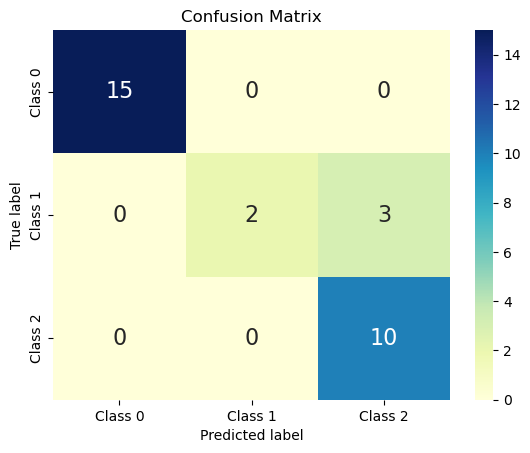

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.40      0.57         5
           2       0.77      1.00      0.87        10

    accuracy                           0.90        30
   macro avg       0.92      0.80      0.81        30
weighted avg       0.92      0.90      0.89        30

n_epoch Model net performance evaluation


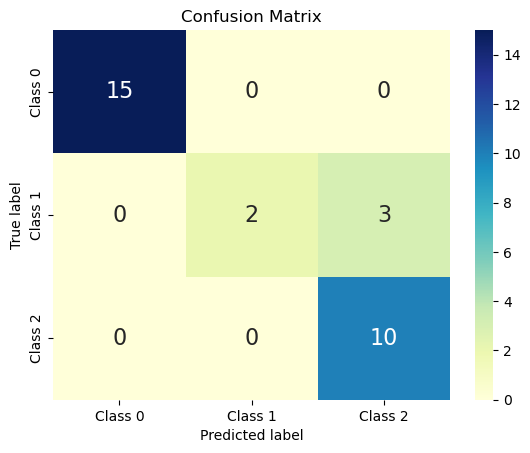

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.40      0.57         5
           2       0.77      1.00      0.87        10

    accuracy                           0.90        30
   macro avg       0.92      0.80      0.81        30
weighted avg       0.92      0.90      0.89        30

Saved Model performance evaluation


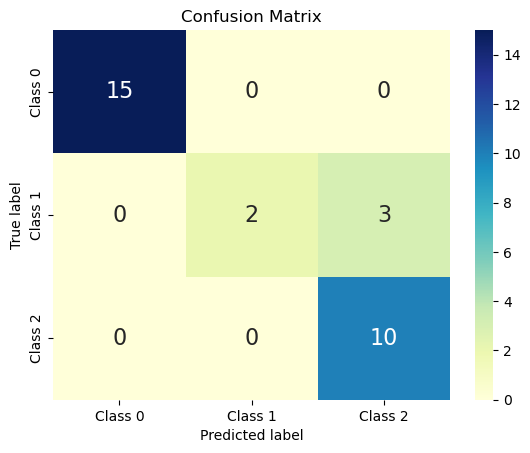

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.40      0.57         5
           2       0.77      1.00      0.87        10

    accuracy                           0.90        30
   macro avg       0.92      0.80      0.81        30
weighted avg       0.92      0.90      0.89        30



In [69]:
# use_val performance
print("Own validation net performance evaluation")
perf_evaluate_plot(Final_test["species"], y_pred_use_val_label, model=3)

# best n_epoch performance
print("n_epoch Model net performance evaluation")
perf_evaluate_plot(Final_test["species"], y_pred_epoch_label, model=3)

# Saved model performance
print("Saved Model performance evaluation")
perf_evaluate_plot(Final_test["species"], y_pred_saved_label, model=3)

#### Final words

The result based on the saved model is not so good. The two-level DL model performed better than this multiclass version. It was actually a bit of a surprise becuase this model was the best-performing model when tested on the actual dataset of the problem that it was built to solve (not IRIS). Out of the three final models, the best model automatically saved from the training phase is much much better that the retrained model, while their performances were comparable on the actual dataset. This highlights the fact that machine learning can be specific and customised solution is usually needed to treat each problem.

Anyways, the idea of this notebook is to demonstrate how to use deep learning neural network to perform classification problem when the model has two-level architecture. It is possible to compare the performance of the classifier of each level to the global performance to observe the performance drop caused by error propagation.